In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import Array
from jax.typing import ArrayLike
from flax.struct import PyTreeNode

import chromatix.functional as cf  # bandaid fix, I added to sys.path in data/data.py
from chromatix.ops import init_plane_resample
from chromatix.utils.initializers import rectangular_microlens_array_amplitude_and_phase

from sample import single_bead_sample
from tensor_tomo import thick_polarised_sample


In [65]:

# %%
class PolScope(PyTreeNode):
    # Initial field & sample
    shape: tuple[int, int] = (256, 256)
    spacing: float = 0.546 / 2  # [mum], 4 nodes / wavelength
    wavelength: float = 0.546  # [mum]

    # universal compensator
    swing: float = 2* jnp.pi * 0.03

    # Condensor
    condenser_f: float = 3333
    condenser_n: float = 1.52
    condenser_NA: float = 1.4

    # objective lens
    objective_f: float = 3333  # [mum]
    objective_n: float = 1.0  # oil immersion
    objective_NA: float = 1.4  # oil immersion

    # tube lens
    tube_f: float = 200_000
    tube_n: float = 1.0
    tube_NA: float = 1.0

    # MLA
    mla_n: float = 1.0
    mla_f: float = 2500
    mla_radius: float = 50
    mla_separation: float = 100
    mla_n_y: float = 15
    mla_n_x: float = 15

    # Camera
    camera_shape: tuple[int, int] = (240, 240)  # (2048, 2048)
    camera_pitch: float = 6.5  # [mum]

    def __call__(self, potential: ArrayLike) -> Array:
        uc_modes = self.universal_compensator_modes(self.swing)
        return jax.jit(jax.vmap(self.forward, in_axes=(0, None)))(uc_modes, potential)

    def forward(self, uc_mode: Array, potential: Array) -> Array:
        # Preliminaries
        z_sample = potential.shape[0] * self.spacing

        # Illumination
        field = cf.objective_point_source(
            self.shape,
            dx=self.spacing,
            spectrum=self.wavelength,
            z=self.condenser_f - z_sample / 2,
            f=self.condenser_f,
            n=self.condenser_n,
            NA=self.condenser_NA,
            amplitude=uc_mode,
        )

        # sample - we have some power gain, we should probably renormalise?
        field = thick_polarised_sample(
            field, potential, 1.33, self.spacing, NA=self.objective_NA
        )

        # propagation over - half / sample as imaging is focused in center of sample
        field = cf.transfer_propagate(
            field, -z_sample / 2, self.objective_n, 512, mode="same"
        )
        print(field.shape)
        
        # Imaging
        # Objective lens - polariser - tube lens
        field = cf.ff_lens(field, self.objective_f, self.objective_n, self.objective_NA)
        field = cf.right_circular_polarizer(field)
        field = cf.ff_lens(field, self.tube_f, self.tube_n, self.tube_NA)

        # MLA and imaging
        field = cf.rectangular_microlens_array(
            field,
            n=self.mla_n,
            f=self.mla_f,
            num_lenses_height=self.mla_n_y,
            num_lenses_width=self.mla_n_x,
            radius=self.mla_radius,
            separation=self.mla_separation,
            block_between=True,
        )
        print(field.shape)
        field = cf.transfer_propagate(field, self.mla_f, self.mla_n, 512, mode="same")

        camera = init_plane_resample(self.camera_shape, self.camera_pitch)(
            field.intensity.squeeze(0), field.dx.squeeze()
        )
        print(camera.shape)
        return field, camera.squeeze()

    def universal_compensator_modes(self, swing: float) -> Array:
        uc_modes = jnp.array(
            [
                [jnp.pi / 2, jnp.pi],
                [jnp.pi / 2 + swing, jnp.pi],
                [jnp.pi / 2, jnp.pi + swing],
                [jnp.pi / 2, jnp.pi - swing],
                [jnp.pi / 2 - swing, jnp.pi],
            ]
        )
        # Universal compensator works on fields, so we use a dummy field.
        field = cf.plane_wave((1, 1), 1, 1, amplitude=cf.linear(0.0))
        field = jax.vmap(cf.universal_compensator, in_axes=(None, 0, 0))(field, uc_modes[:, 0], uc_modes[:, 1])
        amplitudes = field.u.squeeze()

        return amplitudes




(1, 256, 256, 1, 3)
(1, 256, 256, 1, 3)
(240, 240, 1, 1)


TypeError: imshow() missing 1 required positional argument: 'X'

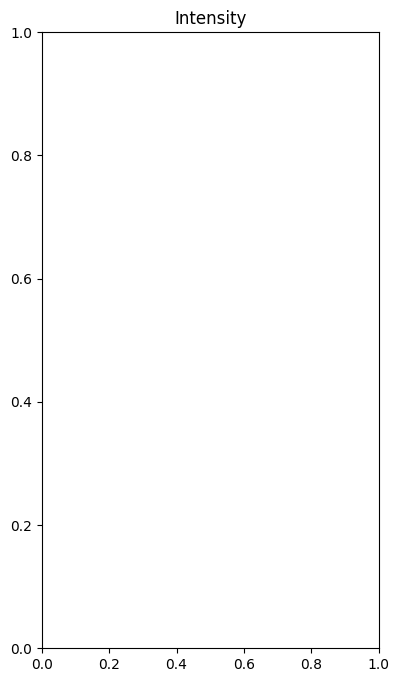

In [66]:
%%time

scope = PolScope()

potential = single_bead_sample(
    1.52,
    jnp.array([1.5, 1.52, 1.52]),
    jnp.array([0, 1/4 * jnp.pi, 0]),
    radius=10.0,
    shape=(256, 256, 256),
    spacing=0.546 / 2,
    k0=2 * jnp.pi / 0.546,
)[:-1, :-1, :-1, None]

# potential = single_bead_sample(
#     1.52,
#     jnp.array([1.37, 1.44, 1.44]),
#     jnp.array([0, 1/4 * jnp.pi, 0]),
#     radius=10.0,
#     shape=(256, 256, 256),
#     spacing=0.546 / 2,
#     k0=2 * jnp.pi / 0.546,
# )[:-1, :-1, :-1, None]


field, image = scope.forward(
    scope.universal_compensator_modes(scope.swing)[1], potential
)

# %% Plotting
plt.figure(figsize=(20, 8))
plt.subplot(141)
plt.title("Intensity")
plt.imshow()
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(142)
plt.title("Ex")
plt.imshow(field.amplitude[0, :, :, 0, 2].squeeze())
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(143)
plt.title("Ey")
plt.imshow(field.amplitude[0, :, :, 0, 1].squeeze())
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(144)
plt.title("Ez")
plt.imshow(field.amplitude[0, :, :, 0, 0].squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

# %%
_, images = scope(potential)

# %%
plt.figure(figsize=(15, 10), layout="tight")
plt.subplot(231)
plt.imshow(images[0])

plt.subplot(232)
plt.imshow(images[1])

plt.subplot(233)
plt.imshow(images[2])

plt.subplot(234)
plt.imshow(images[3])

plt.subplot(235)
plt.imshow(images[4])


# %%
def ret_and_azim_from_intensity(image_list, swing):
    """Calculate the retardance and azimuth from a list of 5 intensity
    using the PolScope 5-frame algorithm."""
    if len(image_list) != 5:
        raise ValueError(f"Expected 5 images, got {len(image_list)}.")
    a = image_list[4] - image_list[1]
    b = image_list[2] - image_list[3]
    den = (
        image_list[1]
        + image_list[2]
        + image_list[3]
        + image_list[4]
        - 4 * image_list[0]
    ) / 2
    prefactor = np.tan(np.pi * swing)

    tmp = np.arctan(
        prefactor * np.sqrt(a**2 + b**2) / (np.abs(den) + np.finfo(float).eps)
    )
    ret = np.where(den == 0, np.pi / 2, tmp)
    ret = np.where(den < 0, np.pi - tmp, ret)

    azim = np.zeros_like(a)
    azim = np.where(
        (a == 0) & (b == 0), 0, (0.5 * (np.arctan2(-a / 2, b) + np.pi)) % np.pi
    )

    return [ret, azim]



# %%
ret, azim = ret_and_azim_from_intensity(images, swing=scope.swing)
# %%

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("retardance")
plt.imshow(ret)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.title("Azimuth")
plt.imshow(azim)
plt.colorbar(fraction=0.046, pad=0.04)
# %% Blocking everything outside
amplitude, phase = rectangular_microlens_array_amplitude_and_phase(
        (240, 240),
        6.5,
        field.spectrum[..., 0, 0].squeeze(),
        1.0,
        1.0,
        15,
        15,
        50,
        100,
    )
mask = amplitude > 0.0

# %%


## masking the MLA

In [52]:
XX.min(), XX.max(), x_mla.min(), x_mla.max()

(np.float64(-776.75), np.float64(783.25), np.int64(-700), np.int64(700))

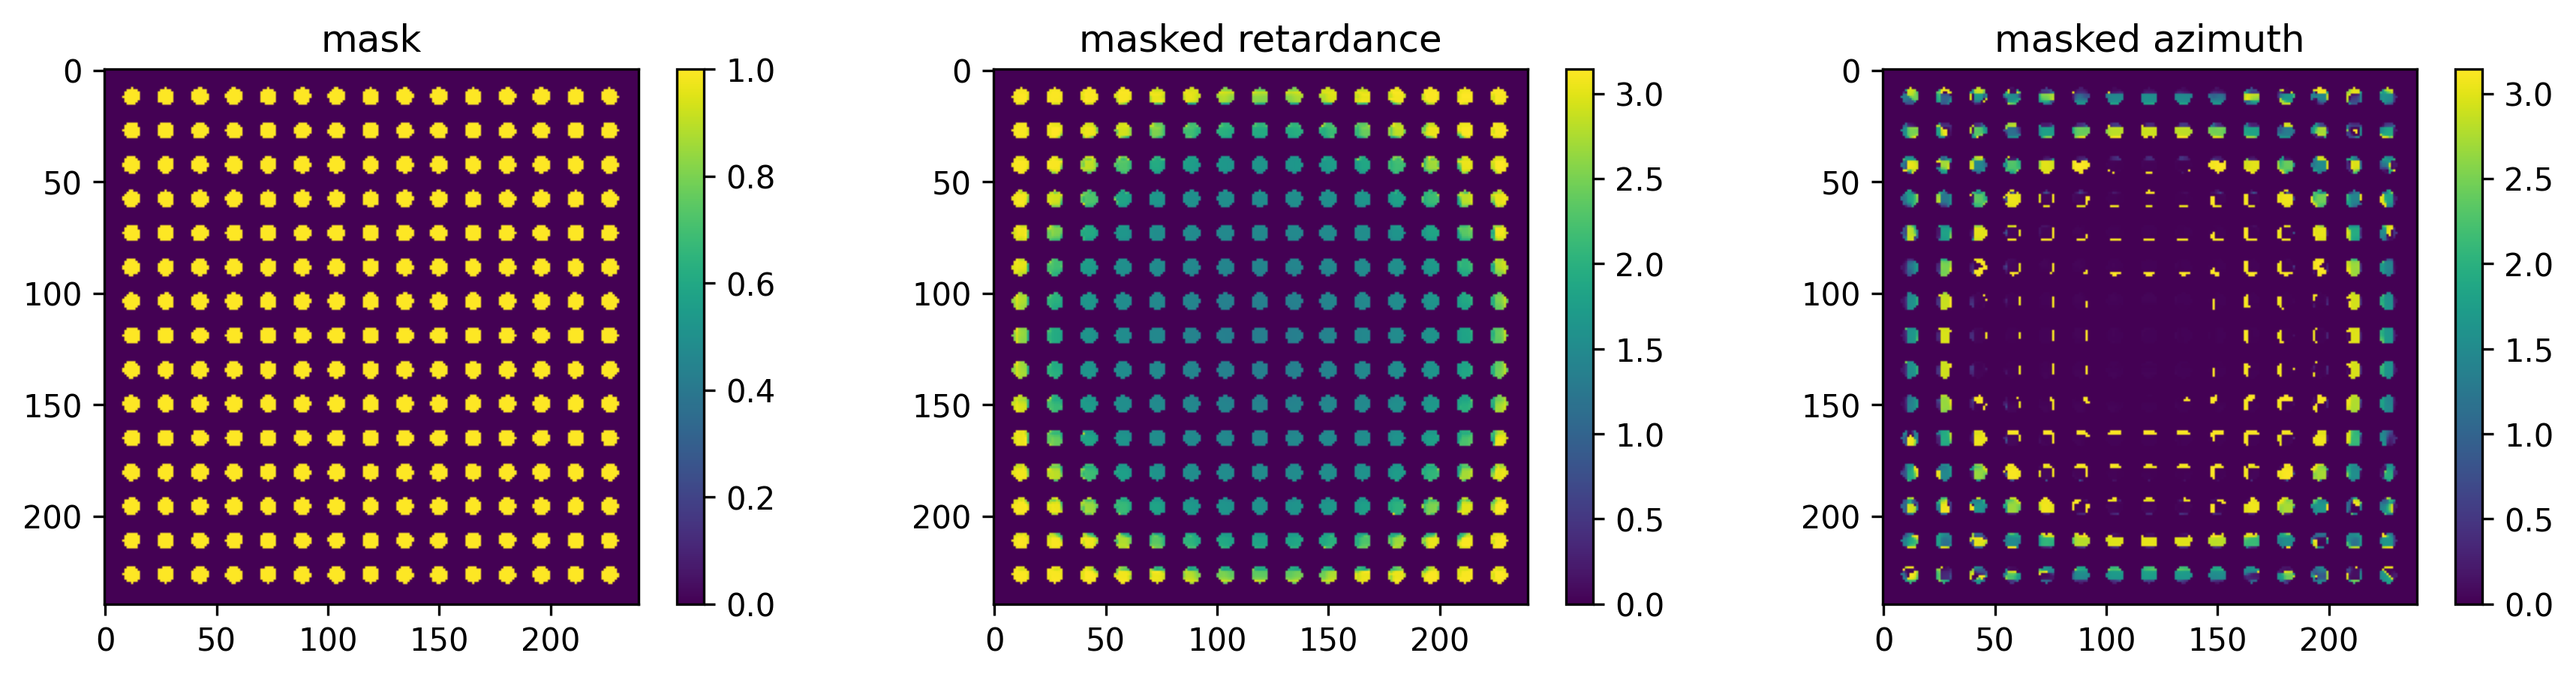

CPU times: user 8.15 s, sys: 678 ms, total: 8.83 s
Wall time: 8.82 s


In [64]:
%%time

N = scope.camera_shape[0]  #scope.shape[0]
s = scope.camera_pitch   #scope.spacing
num_lenses_height = scope.mla_n_y
num_lenses_width = scope.mla_n_x
separation = scope.mla_separation
r = scope.mla_radius

# camera coordinates
det_coord = np.linspace(-N*s/2, N*s/2, N) + s/2
XX, YY = np.meshgrid(det_coord, det_coord)

# MLA coordinates
unit_coordinates = np.meshgrid(
        np.arange(num_lenses_height) - num_lenses_height // 2,
        np.arange(num_lenses_width) - num_lenses_width // 2,
        indexing="ij",
    )
unit_coordinates = np.array(unit_coordinates).reshape(2, num_lenses_height * num_lenses_width)
x_mla, y_mla = unit_coordinates * separation

# make the mask - this takes a few seconds
mask = np.zeros(ret.shape, dtype=bool)
for xc in x_mla:
    for yc in y_mla:
        mask[np.where((XX-xc)**2 + (YY-yc)**2 < (r/2)**2)] = 1


#######################
ret_mla = ret.copy()
azim_mla = azim.copy()
ret_mla[~mask] = 0
azim_mla[~mask] = 0
fig, ax = plt.subplots(1, 3, figsize=[12,3], dpi=300)
ax[0].set_title('mask')
m = ax[0].imshow(mask)
fig.colorbar(m, ax=ax[0])
ax[1].set_title('masked retardance')
m = ax[1].imshow(ret_mla)
fig.colorbar(m, ax=ax[1])
ax[2].set_title('masked azimuth')
m = ax[2].imshow(azim_mla)
fig.colorbar(m, ax=ax[2])
fig.tight_layout()
plt.show()
